In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import ta
from ta.trend import ADXIndicator
from ta.volatility import AverageTrueRange

In [2]:
def adx(high, low, close, window=14):
    """
    Calculate the Average Directional Index (ADX).

    Parameters:
        high (pd.Series): Series of high prices
        low (pd.Series): Series of low prices
        close (pd.Series): Series of close prices
        window (int): The period over which to calculate the ADX (default is 14)

    Returns:
        pd.Series: ADX values indexed the same as the input data
    """
    # Calculate the components of the True Range
    tr = pd.Series(np.max([high - low, abs(high - close.shift(1)), abs(low - close.shift(1))], axis=0), index=close.index)
    tr_smoothed = tr.rolling(window=window, min_periods=1).sum()

    # Calculate +DM and -DM
    plus_dm = high.diff()
    minus_dm = low.diff()
    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0
    minus_dm = minus_dm.abs()

    # Smooth +DM and -DM
    plus_dm_smoothed = plus_dm.rolling(window=window, min_periods=1).sum()
    minus_dm_smoothed = minus_dm.rolling(window=window, min_periods=1).sum()

    # Calculate +DI and -DI
    plus_di = 100 * plus_dm_smoothed / tr_smoothed
    minus_di = 100 * minus_dm_smoothed / tr_smoothed

    # Calculate DX
    dx = 100 * abs((plus_di - minus_di) / (plus_di + minus_di))

    # Calculate ADX
    adx = dx.rolling(window=window, min_periods=1).mean()

    return adx.rename('ADX')

In [3]:

ATR_LENGTH = 14
GRID_SIZE = 10
GRID_STEP = 1
data = pd.read_csv('../BTCdata_clean.csv')

#Add ATR and ADX feature indicators to dataset
data['ATR'] = AverageTrueRange(data['High Price'], data['Low Price'], data['Close Price'], window=ATR_LENGTH).average_true_range()
data['ADX'] = adx(data['High Price'], data['Low Price'], data['Close Price'], window=14)



trades = []


In [4]:
count = 0;
for i in range(len(data)):
    if data['ADX'][i] > 22:
        count = count + 1
print(count/len(data) * 100)
#check how often it spends trending (how tradeable)

68.4895773897828


In [5]:
def checkPrice(grid, idx, balance, ADXLimit = 20, ATRMultiplier = 1, verbose = 0):
    if(idx < ATR_LENGTH):
        return grid
    atr = data['ATR'][idx]
    current_price = data['Close Price'][idx]
    if verbose:
        print('Current Price: ' + str(current_price))
        print('ADX: ' + str(data['ADX'][idx]))

    #if trending, clear grid and wait
    if(data['ADX'][idx] > ADXLimit):
        if verbose:
            print('Trending, clear grid and wait')
        balance.update({'money': balance['money'] + current_price*balance['coinage'], 'coinage': 0})
        grid['buy'].clear()
        grid['sell'].clear()

    #if conditions are met, make a new grid
    if(len(grid['buy']) == 0 or len(grid['sell']) ==0 ):
        grid = create_grid(current_price, grid, atr, ATRMultiplier)
        if verbose:
            print('New Grid Created:')

    #if price hits a level, buy or sell
    if current_price <= max(grid['buy']):
        balance.update({'money': balance['money'] - current_price, 'coinage': balance['coinage']+1})
        grid['buy'].remove(max(grid['buy']))
        if verbose:
            print('bought at ' + str(current_price))
        
        trades.append(('buy', current_price, idx))
    elif current_price >= min(grid['sell']):
        balance.update({'money': balance['money'] + current_price, 'coinage': balance['coinage']-1})
        grid['sell'].remove(min(grid['sell']))
        if verbose:
            print('sold at ' + str(current_price))
        trades.append(('sell', current_price, idx))

    return grid
def create_grid(current_price, grid, atr, ATRMultiplier = 1):
    step = atr*ATRMultiplier
    lower_bound = current_price - GRID_SIZE*step/2
    upper_bound = current_price + GRID_SIZE*step/2
    
    for i in range(5):
        
        grid['buy'].append(lower_bound + i*step)
        grid['sell'].append(upper_bound - i*step)
        
    return grid


In [9]:
def test_grid(ADXLimit, ATRMultiplier, data = data):
    grid = {
    'buy' : [],
    'sell' : []
    }
    balance = {'money': 0, 'coinage' : 0}
    dataLimit = 100000
    # dataLimit = int(len(data['High Price'])/2)
    data = data[:dataLimit]
    for i in range(dataLimit):
        count = 0
        
        grid = checkPrice(grid= grid, idx=i, balance=balance, ADXLimit = ADXLimit, ATRMultiplier = ATRMultiplier)

    print(balance)

    if(balance['coinage'] != 0):
        balance.update({'money': balance['money'] + data['Close Price'][dataLimit-1]*balance['coinage'], 'coinage': 0})
        print('Liquified Balance' + str(balance))
    return balance

adxTests = [15, 20, 25, 30, 35, 40, 45, 50]
atrTests = [0.5, 1, 1.5, 2, 2.5, 3]
results = {}
for adx in adxTests:
    for atr in atrTests:
        print('Testing ADX: ' + str(adx) + ' ATR: ' + str(atr))
        results.update({str('ADX:'+str(adx) +' ATR: '+ str(atr)):test_grid(adx, atr)})


Testing ADX: 15 ATR: 0.5
{'money': -1687.9100000001708, 'coinage': 0}
Testing ADX: 15 ATR: 1
{'money': -46840.97000000001, 'coinage': 1}
Liquified Balance{'money': -104.36000000000786, 'coinage': 0}
Testing ADX: 15 ATR: 1.5
{'money': -71.3300000000163, 'coinage': 0}
Testing ADX: 15 ATR: 2
{'money': 613.6199999999371, 'coinage': 0}
Testing ADX: 15 ATR: 2.5
{'money': 11.569999999934225, 'coinage': 0}
Testing ADX: 15 ATR: 3
{'money': 24.279999999969732, 'coinage': 0}
Testing ADX: 20 ATR: 0.5
{'money': 137749.40999999986, 'coinage': -3}
Liquified Balance{'money': -2460.4200000001583, 'coinage': 0}
Testing ADX: 20 ATR: 1
{'money': 93354.5399999998, 'coinage': -2}
Liquified Balance{'money': -118.68000000019674, 'coinage': 0}
Testing ADX: 20 ATR: 1.5
{'money': 46931.04999999985, 'coinage': -1}
Liquified Balance{'money': 194.43999999984953, 'coinage': 0}
Testing ADX: 20 ATR: 2
{'money': 46878.75999999987, 'coinage': -1}
Liquified Balance{'money': 142.1499999998705, 'coinage': 0}
Testing ADX: 2

In [7]:
print(grid['buy'])

NameError: name 'grid' is not defined

In [ ]:
print(grid['sell'])

[39185.09138208297, 39164.735105666376, 39144.37882924978]


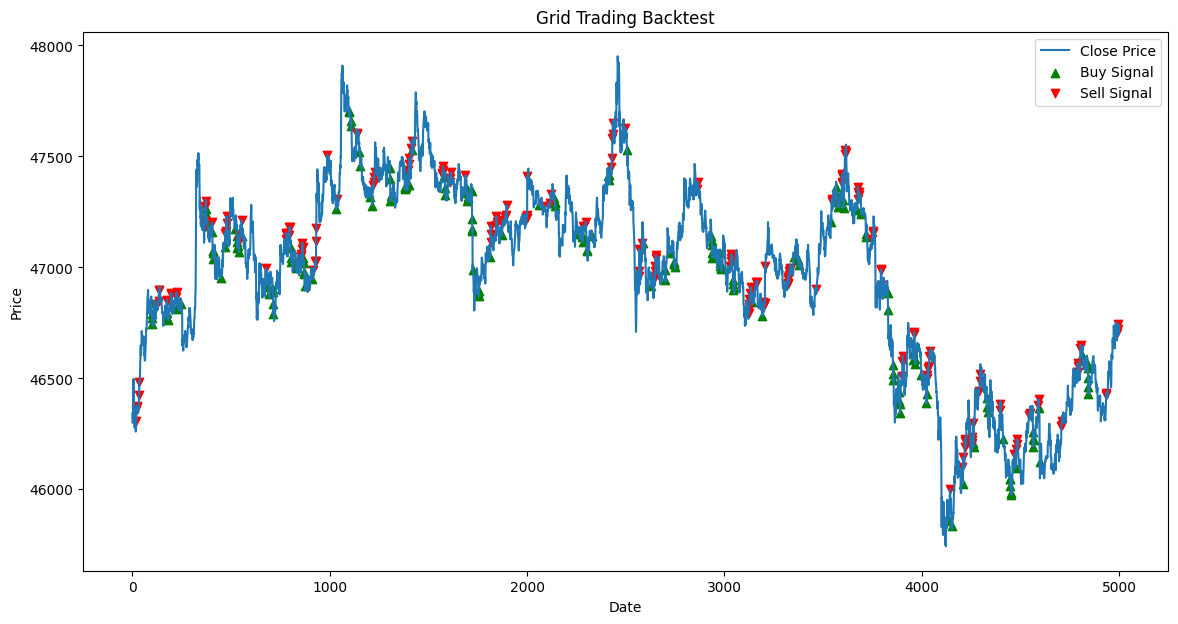

In [ ]:
# Extract buy and sell points for plotting
buys = [data['Close Price'].iloc[i] for action, price, i in trades if action == 'buy']
sells = [data['Close Price'].iloc[i] for action, price, i in trades if action == 'sell']
buy_indices = [i for action, price, i in trades if action == 'buy']
sell_indices = [i for action, price, i in trades if action == 'sell']



# Plotting results
plt.figure(figsize=(14, 7))
plt.plot(data['Close Price'], label='Close Price')
plt.scatter(buy_indices, buys, color='green', label='Buy Signal', marker='^', alpha=1)
plt.scatter(sell_indices, sells, color='red', label='Sell Signal', marker='v', alpha=1)
plt.title('Grid Trading Backtest')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()